<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

# Collaborative Filtering

Estimated time needed: **25** minutes

## Objectives

After completing this lab you will be able to:

*   Create recommendation system based on collaborative filtering


Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user. These systems have become ubiquitous can be commonly seen in online stores, movies databases and job finders. In this notebook, we will explore recommendation systems based on Collaborative Filtering and implement simple version of one using Python and the Pandas library.


<h2>Table of contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Acquiring the Data</a></li>
        <li><a href="#ref2">Preprocessing</a></li>
        <li><a href="#ref3">Collaborative Filtering</a></li>
    </ol>
</div>
<br>
<hr>

# Import necessary modules

First, let's get all of the imports out of the way:


In [133]:
#Dataframe manipulation library
import pandas as pd
#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="ref1"></a>
# Acquiring the Data

To acquire and extract the data, simply run the following Bash scripts:\
Dataset acquired from [GroupLens](http://grouplens.org/datasets/movielens/?utm_medium=Exinfluencer\&utm_source=Exinfluencer\&utm_content=000026UJ\&utm_term=10006555\&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01). Let's download the dataset. To download the data, we will use **`!wget`** to download it from IBM Object Storage.\
**Did you know?** When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


**Download data**<br>
In this lab I use the smaller dataset, but feel free to use the complete dataset
```python
!wget -O ml-latest-small.zip https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
```

**Extract zip file**<br>
```python
from zipfile import ZipFile

with ZipFile('ml-latest-small.zip' , 'r') as zip_ref:
    zip_ref.extractall()
```

# Preprocessing

Now let's read each file into their Dataframes:


In [134]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

## `movies_df`

In [135]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Remove year from `title` and present it in a new column

So each movie has a unique ID, a title with its release year along with it (Which may contain unicode characters) and several different genres in the same field. Let's remove the year from the title column and place it into its own one by using the handy [extract](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.extract.html?utm_medium=Exinfluencer\&utm_source=Exinfluencer\&utm_content=000026UJ\&utm_term=10006555\&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01#pandas.Series.str.extract) function that Pandas has.


Let's remove the year from the **title** column by using pandas' replace function and store in a new **year** column.


In [136]:
#Extract year with parantheses from 'title'
#so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)

In [137]:
#Extract year without parentheses from 'year'
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)

In [138]:
#Remove the years (with parantheses) from the 'title' 
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')

In [139]:
#Apply strip function to get rid of any ending whitespace characters
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

In [140]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


### Drop `genre` column 

With that, let's also drop the genres column since we won't need it for this particular recommendation system.


In [141]:
#Dropping the genres column
movies_df = movies_df.drop('genres', 1)

Here's the final movies dataframe:


In [142]:
movies_df.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


## `ratings_df`

Next, let's look at the ratings dataframe.


In [143]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [144]:
ratings_df.shape

(100836, 4)

### Drop `timestamp` column
Every row in the ratings dataframe has a user id associated with at least one movie, a rating and a timestamp showing when they reviewed it. We won't be needing the timestamp column, so let's drop it to save on memory.


In [145]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)

Here's how the final ratings Dataframe looks like:


In [146]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Collaborative Filtering

Now it's time to start our work on recommendation systems.

The first technique we're going to take a look at is called **Collaborative Filtering**, which is also known as **User-User Filtering**. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the **Pearson Correlation Function**.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/images/User_Item.png" width=800px>

The process for creating a User Based recommendation system is as follows:

*   Select a user with the movies the user has watched
*   Based on his rating to movies, find the top X neighbours
*   Get the watched movie record of the user for each neighbour.
*   Calculate a similarity score using some formula
*   Recommend the items with the highest score

## 1. Create input user - seen movies with ratings 
Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .

In [147]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


### Add movie Id to input user -> `inputMovies` data frame

With the input complete, let's extract the input movies's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.


In [148]:
#Filtering out the movies by title in movies_df
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputId

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
257,296,Pulp Fiction,1994
973,1274,Akira,1988
1445,1968,"Breakfast Club, The",1985


In [149]:
inputMovies = pd.merge(inputId, inputMovies)
inputMovies = inputMovies.drop('year', 1)
inputMovies = inputMovies.sort_values(by='movieId')

inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,1968,"Breakfast Club, The",5.0


## 2. Create common user matrix

### Filter out `ratings_df` by movie Id -> `userSubset`
Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.

In [150]:
#Filtering out watched movies by movieID
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
0,1,1,4.0
16,1,296,3.0
320,4,296,1.0
422,4,1968,4.0
516,5,1,4.0


In [151]:
userSubset.shape

(784, 3)

### Group `userSubset` by user Id
There's 419 users that have watched the same movies 

In [152]:
userSubset['userId'].nunique()

419

We now group up the rows by user ID.

In [153]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['userId'])

Let's look at one of the users, e.g. the one with userID=610. Observe that there is 4 movies in common 


In [154]:
userSubsetGroup.get_group(610)

,userId,movieId,rating
99534,610,1,5.0
99552,610,296,5.0
99636,610,1274,5.0
99664,610,1968,4.0


Display first 5 groups and their content 

In [155]:
for gr, data in list(userSubsetGroup)[0:5]: #loop through first 5 rows (groups)
    print(gr,'\n',data,'\n')

1 
     userId  movieId  rating
0        1        1     4.0
16       1      296     3.0 

4 
      userId  movieId  rating
320       4      296     1.0
422       4     1968     4.0 

5 
      userId  movieId  rating
516       5        1     4.0
533       5      296     5.0 

6 
      userId  movieId  rating
560       6        2     4.0
692       6      296     2.0 

7 
      userId  movieId  rating
874       7        1     4.5 



In [156]:
len(list(userSubsetGroup))

419

### Sort the groups by number of common movies -> `userSubsetGroup`
Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.


In [157]:
#Sorting it in reverse (reserve=True) so users with 
#movie most in common (most rows - check by len function)
#with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now let's look at the first 3 users with most in common


In [158]:
userSubsetGroup[0:3] #each element has two items - userId and data 

[(91,
         userId  movieId  rating
  14121      91        1     4.0
  14122      91        2     3.0
  14173      91      296     4.5
  14316      91     1274     5.0
  14383      91     1968     3.0),
 (177,
         userId  movieId  rating
  24900     177        1     5.0
  24901     177        2     3.5
  24930     177      296     5.0
  25069     177     1274     2.0
  25129     177     1968     3.5),
 (219,
         userId  movieId  rating
  31524     219        1     3.5
  31525     219        2     2.5
  31554     219      296     4.0
  31628     219     1274     2.5
  31680     219     1968     3.0)]

## 3. Create user similairity (weight) matrix

Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.\
we're going to find out how similar each user is to the input through the **Pearson Correlation Coefficient**. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 \* Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

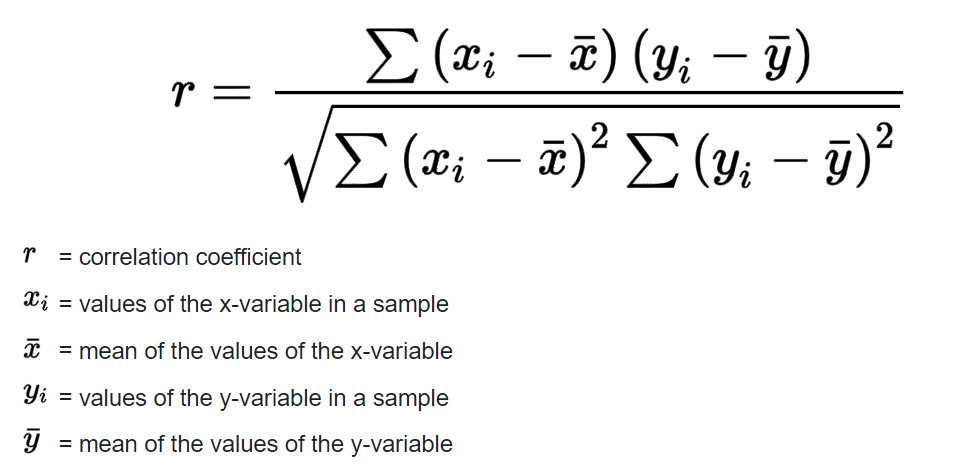

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.


### Subset `userSubsetGroup` to 100 users Id

Practice slicing the first element of the list 

In [159]:
userSubsetGroup[0][0] #userId

91

In [160]:
userSubsetGroup[0][1] #data

,userId,movieId,rating
14121,91,1,4.0
14122,91,2,3.0
14173,91,296,4.5
14316,91,1274,5.0
14383,91,1968,3.0


In [161]:
len(userSubsetGroup[0][1]) #how many common movies 

5

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [162]:
userSubsetGroup = userSubsetGroup[0:100]

### Calculate Pearson Correlation 

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient. A simplified formula will be as below:
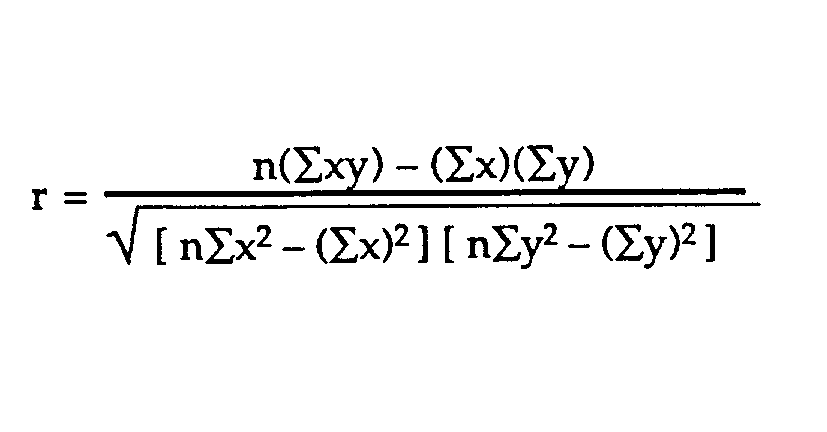

Compute similarity between input user's ratings to the rest of the users'

In [163]:
#Store the Pearson Correlation in a dictionary, where the key:userId , value:coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup: #-> name:userId , group:data frame
    #Get of rows of data
    nRatings = len(group)  
    
    #Input user ratings - input user must watch what the common user watches 
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist() #-> x variable 
    #Common user ratings 
    tempGroupList = group['rating'].tolist() #-> y variable
    
    #Numerator
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    #Denominator
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0

In [164]:
pearsonCorrelationDict.items() #-> key:id , value:similarity

dict_items([(91, 0.43852900965351443), (177, 0.0), (219, 0.45124262819713973), (274, 0.716114874039432), (298, 0.9592712306918567), (414, 0.9376144618769914), (474, 0.11720180773462392), (477, 0.4385290096535153), (480, 0.7844645405527362), (483, 0.08006407690254357), (599, 0.7666866491579839), (608, 0.920736884379251), (50, 0.15713484026367722), (57, -0.7385489458759964), (68, 0.0), (103, 0.5222329678670935), (135, 0.8703882797784892), (182, 0.9428090415820635), (202, 0.5222329678670935), (217, 0.30151134457776363), (226, 0.9438798074485389), (288, 0.6005325641789633), (307, 0.9655810287305759), (318, 0.44486512077567225), (322, 0.5057805388588731), (330, 0.9035942578600878), (357, 0.5606119105813882), (434, 0.9864036607532465), (448, 0.30151134457776363), (469, 0.8164965809277261), (561, 0.5222329678670935), (600, 0.18442777839082938), (606, 0.9146591207600472), (610, -0.47140452079103173), (18, 1.0), (19, -0.5), (21, 0), (45, 0.5000000000000009), (63, -0.4999999999999982), (64, 0.0)

In [165]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index', columns=['similarityIndex'])
pearsonDF.head() #we can see the userId is in index and the column of similarity is not named 

,similarityIndex
91,0.438529
177,0.000000
219,0.451243
274,0.716115
298,0.959271


In [166]:
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))

pearsonDF.head()

,similarityIndex,userId
0,0.438529,91
1,0.000000,177
2,0.451243,219
3,0.716115,274
4,0.959271,298


In [167]:
pearsonDF.shape

(100, 2)

### Find the top 50 similar users to input user -> `topUsers`

Now let's get the top 50 users that are most similar to the input.


In [168]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
43,1.0,132
34,1.0,18
63,1.0,305
82,1.0,489
86,1.0,525


Now, let's start recommending movies to the input user.

## 4. Create weighted ratings matrix 

We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our **pearsonDF** from the ratings dataframe and then store their correlation in a new column called `similarityIndex`. This is achieved below by merging of these two tables.


### Merge `topUsers` to `ratings_df` based on the user Id -> `topUsersRating`

In [169]:
topUsers.keys()

Index(['similarityIndex', 'userId'], dtype='object')

In [170]:
#only matching userId will be merged
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,132,1,2.0
1,1.0,132,17,3.0
2,1.0,132,29,2.0
3,1.0,132,32,3.0
4,1.0,132,34,1.5


In [171]:
topUsersRating.shape

(27831, 4)

### Multiply ratings with its weight (similarity)
Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

In [172]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,132,1,2.0,2.0
1,1.0,132,17,3.0,3.0
2,1.0,132,29,2.0,2.0
3,1.0,132,32,3.0,3.0
4,1.0,132,34,1.5,1.5


### Sum up all similarity indexes and all weighted rantings -> `tempTopUsersRating`
We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [173]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,36.354096,133.167946
2,31.005292,94.904257
3,8.783859,26.381456
4,0.866025,1.732051
5,7.165336,19.775255


### Divide sum of indexs by sum of weighted ratings

In [174]:
#Now we take the weighted average
tempTopUsersRating['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating,weighted average recommendation score
movieId,,,
1,36.354096,133.167946,3.663080
2,31.005292,94.904257,3.060905
3,8.783859,26.381456,3.003402
4,0.866025,1.732051,2.000000
5,7.165336,19.775255,2.759850


In [183]:
tempTopUsersRating.shape

(6109, 3)

## 5. Create recommendation matrix

In [182]:
recommendation_df = tempTopUsersRating.copy()
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.index = range(len(tempTopUsersRating.index))
recommendation_df.drop(columns=['sum_similarityIndex', 'sum_weightedRating'], inplace=True)
recommendation_df.head()

,weighted average recommendation score,movieId
0,3.663080,1
1,3.060905,2
2,3.003402,3
3,2.000000,4
4,2.759850,5


Now let's sort it and see the top 10 movies that the algorithm recommended!


In [184]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
1990,5.0,3310
3796,5.0,7579
546,5.0,905
731,5.0,1211
5914,5.0,140627
2525,5.0,4298
5964,5.0,152711
431,5.0,633
3084,5.0,5537
3063,5.0,5485


In [185]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,year
536,633,Denise Calls Up,1995
687,905,It Happened One Night,1934
912,1211,"Wings of Desire (Himmel über Berlin, Der)",1987
2484,3310,"Kid, The",1921
3189,4298,Rififi (Du rififi chez les hommes),1955
3905,5485,Tadpole,2002
3936,5537,Satin Rouge,2002
4969,7579,Pride and Prejudice,1940
9022,140627,Battle For Sevastopol,2015
9234,152711,Who Killed Chea Vichea?,2010


# Advantages and Disadvantages of Collaborative Filtering

## Advantages

*   Takes other user's ratings into consideration
*   Doesn't need to study or extract information from the recommended item
*   Adapts to the user's interests which might change over time

## Disadvantages

*   Approximation function can be slow
*   There might be a low of amount of users to approximate
*   Privacy issues when trying to learn the user's preferences
